In [19]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight

In [20]:
root_dir = '/kaggle/input/lalalala/new_fer2013_cropped/train'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

In [21]:
classes

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [22]:
dataset_path = '/kaggle/input/lalalala/new_fer2013_cropped'

In [23]:
mean = 0.456
std = 0.224
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((48, 48)),             
    transforms.RandomRotation(degrees=15),       
    transforms.RandomHorizontalFlip(p=0.5),     
    transforms.RandomVerticalFlip(p=0.5),   
    transforms.ToTensor(),
    transforms.RandomErasing(
        p=0.5,                  
        scale=(0.01, 0.2),     
        ratio=(0.2, 2.2),  
        value=0                
    ),
    transforms.Normalize([0.456], [0.224])
])

In [24]:
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
train_labels = train_dataset.targets  
class_indices = list(range(len(classes)))
class_weights = compute_class_weight(
    'balanced', 
    classes=class_indices, 
    y=train_labels
)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

Feature batch shape: torch.Size([32, 1, 48, 48])
Labels batch shape: torch.Size([32])


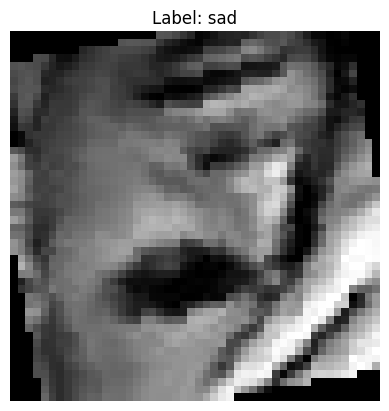

In [28]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[5].permute(1, 2, 0)  # C, H, W -> H, W, C
img = img * std + mean  # unnormalize back to [0,1] range
img = img.clamp(0, 1)
label = train_labels[5].item()
plt.imshow(img.numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

In [29]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(x + self.block(x))


In [31]:
class ResNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=7):
        super(ResNet, self).__init__()

        self.model = nn.Sequential(
            ConvBlock(in_channels, 64),
            ConvBlock(64, 64),
            ResidualBlock(64),
            ResidualBlock(64),

            ConvBlock(64, 128),
            ConvBlock(128, 128),
            ResidualBlock(128),
            ResidualBlock(128),

            ConvBlock(128, 256),
            ConvBlock(256, 256),
            ResidualBlock(256),
            ResidualBlock(256),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [32]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    in_channels=1, 
    num_classes=n_classes
).to(device)

In [33]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [34]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0.0

    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        total_samples = 0

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0) 
            train_correct += (torch.argmax(outputs, 1) == labels).sum().item()
            total_samples += labels.size(0)

        train_loss /= total_samples
        train_acc = train_correct / total_samples
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
            print(f'Best model saved with val acc: {val_acc:.4f}')

        print(f'EPOCH {epoch + 1}/{epochs}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tTrain accuracy: {train_acc:.4f}\tVal accuracy: {val_acc:.4f}')
        scheduler.step()

    return train_losses, val_losses, train_accs, val_accs


In [35]:
epochs = 50

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
    momentum=0.9 
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [36]:
train_losses, val_losses, train_accs, val_accs = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

Best model saved with val acc: 0.2249
EPOCH 1/50:	Train loss: 1.9367	Val loss: 1.8814	Train accuracy: 0.2009	Val accuracy: 0.2249
Best model saved with val acc: 0.3044
EPOCH 2/50:	Train loss: 1.8640	Val loss: 1.7715	Train accuracy: 0.2486	Val accuracy: 0.3044
EPOCH 3/50:	Train loss: 1.8309	Val loss: 1.8392	Train accuracy: 0.2641	Val accuracy: 0.2408
Best model saved with val acc: 0.3242
EPOCH 4/50:	Train loss: 1.7952	Val loss: 1.7014	Train accuracy: 0.2916	Val accuracy: 0.3242
Best model saved with val acc: 0.3350
EPOCH 5/50:	Train loss: 1.7566	Val loss: 1.6861	Train accuracy: 0.3240	Val accuracy: 0.3350
Best model saved with val acc: 0.3531
EPOCH 6/50:	Train loss: 1.7346	Val loss: 1.6980	Train accuracy: 0.3329	Val accuracy: 0.3531
EPOCH 7/50:	Train loss: 1.6990	Val loss: 1.6979	Train accuracy: 0.3544	Val accuracy: 0.3225
Best model saved with val acc: 0.3664
EPOCH 8/50:	Train loss: 1.6847	Val loss: 1.6242	Train accuracy: 0.3585	Val accuracy: 0.3664
Best model saved with val acc: 0.388

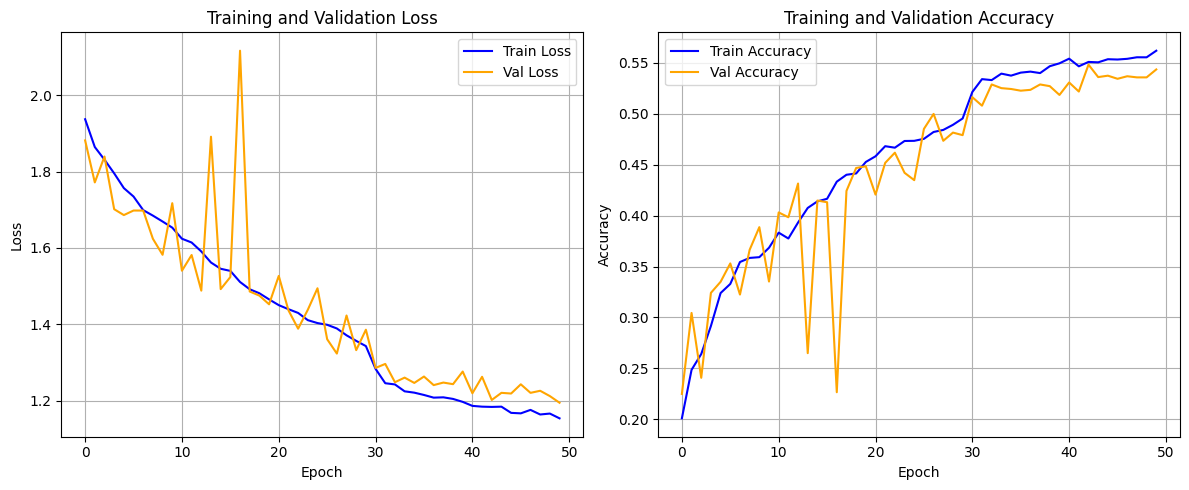

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(train_losses, color='blue', label='Train Loss')
ax[0].plot(val_losses, color='orange', label='Val Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(train_accs, color='blue', label='Train Accuracy')
ax[1].plot(val_accs, color='orange', label='Val Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [38]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5440644981929386
Test accuracy:  0.5501169395255596


In [39]:
from google.colab import files

# Specify the file you want to download
files.download('/content/best_model.pth')  # Example: Replace with your file path


FileNotFoundError: Cannot find file: /content/best_model.pth